### FFT Speedtest comparing Tensorflow, PyTorch, CuPy, PyFFTW and NumPy.

I test the performance of taking an inverse 2D fft on the regular 2D fft of arrays of size 512x512, 1024x1024, 2048x2048 and 4096x4096. The data type is set to Complex 64-bit (Equivalent of float32 for complex numbers) for compatability.

GPUs are individual NVidia RTX 2080TI with 11GB of ram.

The system has 4 of them, each GPU fft implementation runs on its own GPU.

CPU is a 28-core Intel Xeon Gold 5120 CPU @ 2.20GHz 

Test by @thomasaarholt

**See bottom for graphs.**

**TLDR: PyTorch GPU fastest and is 4.5 times faster than TensorFlow GPU and CuPy, and the PyTorch CPU version outperforms every other CPU implementation by at least 57 times (including PyFFTW).**

My best guess on why the PyTorch cpu solution is better is that it possibly better at taking advantage of the multi-core CPU system the code ran on.

In [67]:
%matplotlib inline
import tensorflow as tf
import torch
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pyfftw
# Print numpy see whether mkl/blas is available
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']

In [66]:
print('TensorFlow: {}'.format(tf.__version__))
print('PyTorch: {}'.format(torch.__version__))
print('Numpy: {}'.format(np.__version__))
print('CuPy: {}'.format(cp.__version__))
print('pyFFTW: {}'.format(pyfftw.__version__))

TensorFlow: 2.0.0-beta1
PyTorch: 1.2.0
Numpy: 1.16.4
CuPy: 6.4.0
pyFFTW: 0.11.1


In [4]:
# Helper functions for each package
def tf_ifft2_fft2(data):
    data2 = tf.signal.fft2d(data)
    return tf.signal.ifft2d(data2)

def torch_ifft2_fft2(data):
    signal_ndim = 2
    data2 = torch.fft(data, signal_ndim=signal_ndim)
    return torch.ifft(data2, signal_ndim=signal_ndim)

def np_ifft2_fft2(data):
    data2 = np.fft.fft2(data)
    return np.fft.ifft2(data2)

def cp_ifft2_fft2(data):
    data2 = cp.fft.fft2(data)
    return cp.fft.ifft2(data2)

def pyfftw_ifft2_fft2(data):
    data2 = pyfftw.interfaces.numpy_fft.fft2(data)
    return pyfftw.interfaces.numpy_fft.ifft2(data2)

In [5]:
# Checking that the functions produce the same result
# Using some helper functions to turn all data into numpy arrays
from pyms.utils import cx_from_numpy, cx_to_numpy
data = np.random.random((20,20)).astype('complex64')

dtf = tf_ifft2_fft2(data).numpy()
dtorch = cx_to_numpy(torch_ifft2_fft2(cx_from_numpy(data)))
dcp = cp.asnumpy(cp_ifft2_fft2(cp.array(data)))
dnp = np_ifft2_fft2(data)
dfftw = pyfftw_ifft2_fft2(data)

In [6]:
# Not equal to seven decimals
np.testing.assert_almost_equal(dtf, dtorch, decimal=6)
np.testing.assert_almost_equal(dtf, dcp, decimal=6)
np.testing.assert_almost_equal(dtf, dnp, decimal=6)
np.testing.assert_almost_equal(dtf, dnp, decimal=6)
np.testing.assert_almost_equal(dtf, dfftw, decimal=6)

### Setting up measurement

In [7]:
sizes = [512, 1024, 2048, 4096] # X * X pixel arrays/tensors

In [8]:
names = []
totaltimes = []

### TensorFlow CPU

In [9]:
name = 'TensorFlow\nCPU'
names.append(name)
with tf.device("/device:CPU:0"):
    tensortimes = []
    datas = [tf.dtypes.cast(tf.random.normal(shape=(x,x)), dtype = tf.complex128) for x in sizes]
    print(f'Working on device: {datas[0].device}')
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o tf_ifft2_fft2(data)
        tensortimes.append(t)
    totaltimes.append(tensortimes)

Working on device: /job:localhost/replica:0/task:0/device:CPU:0
TensorFlow CPU 512x512
49.1 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
TensorFlow CPU 1024x1024
229 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TensorFlow CPU 2048x2048
1.29 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TensorFlow CPU 4096x4096
5.72 s ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TensorFlow GPU

In [10]:
name = 'TensorFlow\nGPU'
names.append(name)
print('{} available: {}'.format(name, tf.test.is_gpu_available()))
with tf.device("/device:GPU:3"):
    tensortimes = []
    datas = [tf.dtypes.cast(tf.random.normal(shape=(x,x)), dtype = tf.complex128) for x in sizes]
    print(f'Working on device: {datas[0].device}')
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o tf_ifft2_fft2(data)
        tensortimes.append(t)
    totaltimes.append(tensortimes)

TensorFlow
GPU available: True
Working on device: /job:localhost/replica:0/task:0/device:GPU:3
TensorFlow GPU 512x512
1.94 ms ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
TensorFlow GPU 1024x1024
2.37 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
TensorFlow GPU 2048x2048
3.22 ms ± 934 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
TensorFlow GPU 4096x4096
16.2 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### PyTorch CPU

In [11]:
name = 'PyTorch\nCPU'
device_type = 'cpu'
device = torch.device(device_type)
names.append(name)
torchtimes = []
datas = [torch.randn((x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft2_fft2(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

Working on device: cpu
PyTorch CPU 512x512
506 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch CPU 1024x1024
1.26 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch CPU 2048x2048
14.5 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
PyTorch CPU 4096x4096
61.3 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### PyTorch GPU

In [12]:
name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:2')
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))
torchtimes = []
datas = [torch.randn(size=(x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft2_fft2(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

# # Clear pytorch memory
# del datas
# torch.cuda.empty_cache()

PyTorch
GPU available: True
Working on device: cuda:2
PyTorch GPU 512x512
101 µs ± 5.15 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyTorch GPU 1024x1024
194 µs ± 98.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
PyTorch GPU 2048x2048
906 µs ± 102 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch GPU 4096x4096
3.58 ms ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Numpy

In [13]:
name = 'Numpy\nCPU'
names.append(name)
nptimes = []
datas = [np.random.normal(size=(x,x)).astype('complex128') for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o np_ifft2_fft2(data)
    nptimes.append(t)
totaltimes.append(nptimes)

Numpy CPU 512x512
24.9 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy CPU 1024x1024
150 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy CPU 2048x2048
831 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 4096x4096
3.49 s ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### CuPy

In [14]:
name = 'CuPy\nGPU'
names.append(name)
cptimes = []
device = cp.cuda.Device(1)
with device:
    datas = [cp.random.normal(size=(x,x)).astype('complex128') for x in sizes]
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o cp_ifft2_fft2(data)
        cptimes.append(t)
    totaltimes.append(cptimes)

# # Clear cupy memory
# mempool = cp.get_default_memory_pool()
# del datas
# mempool.free_all_blocks()

CuPy GPU 512x512
2.38 ms ± 84 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
CuPy GPU 1024x1024
2.64 ms ± 712 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CuPy GPU 2048x2048
3.56 ms ± 835 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CuPy GPU 4096x4096
17.1 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### PyFFTW

In [15]:
name = 'PyFFTW\nCPU'
names.append(name)
tensortimes = []
def pyfftw_array(shape):
    arr = pyfftw.empty_aligned(shape, dtype='complex128')
    arr[:] = np.random.normal(size=shape) + 1j*np.random.normal(size=shape)
    return arr
datas = [pyfftw_array((x,x)) for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o pyfftw_ifft2_fft2(data)
    tensortimes.append(t)
totaltimes.append(tensortimes)

# a = pyfftw.empty_aligned((512, 512), dtype='complex128', n=16)
# a[:] = np.random.random((512, 512)) + 1j*np.random.random((512, 512))
# %%timeit
# b = pyfftw.interfaces.numpy_fft.fft(a)

PyFFTW CPU 512x512
24.2 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
PyFFTW CPU 1024x1024
146 ms ± 976 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
PyFFTW CPU 2048x2048
829 ms ± 7.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyFFTW CPU 4096x4096
3.91 s ± 55.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plotting

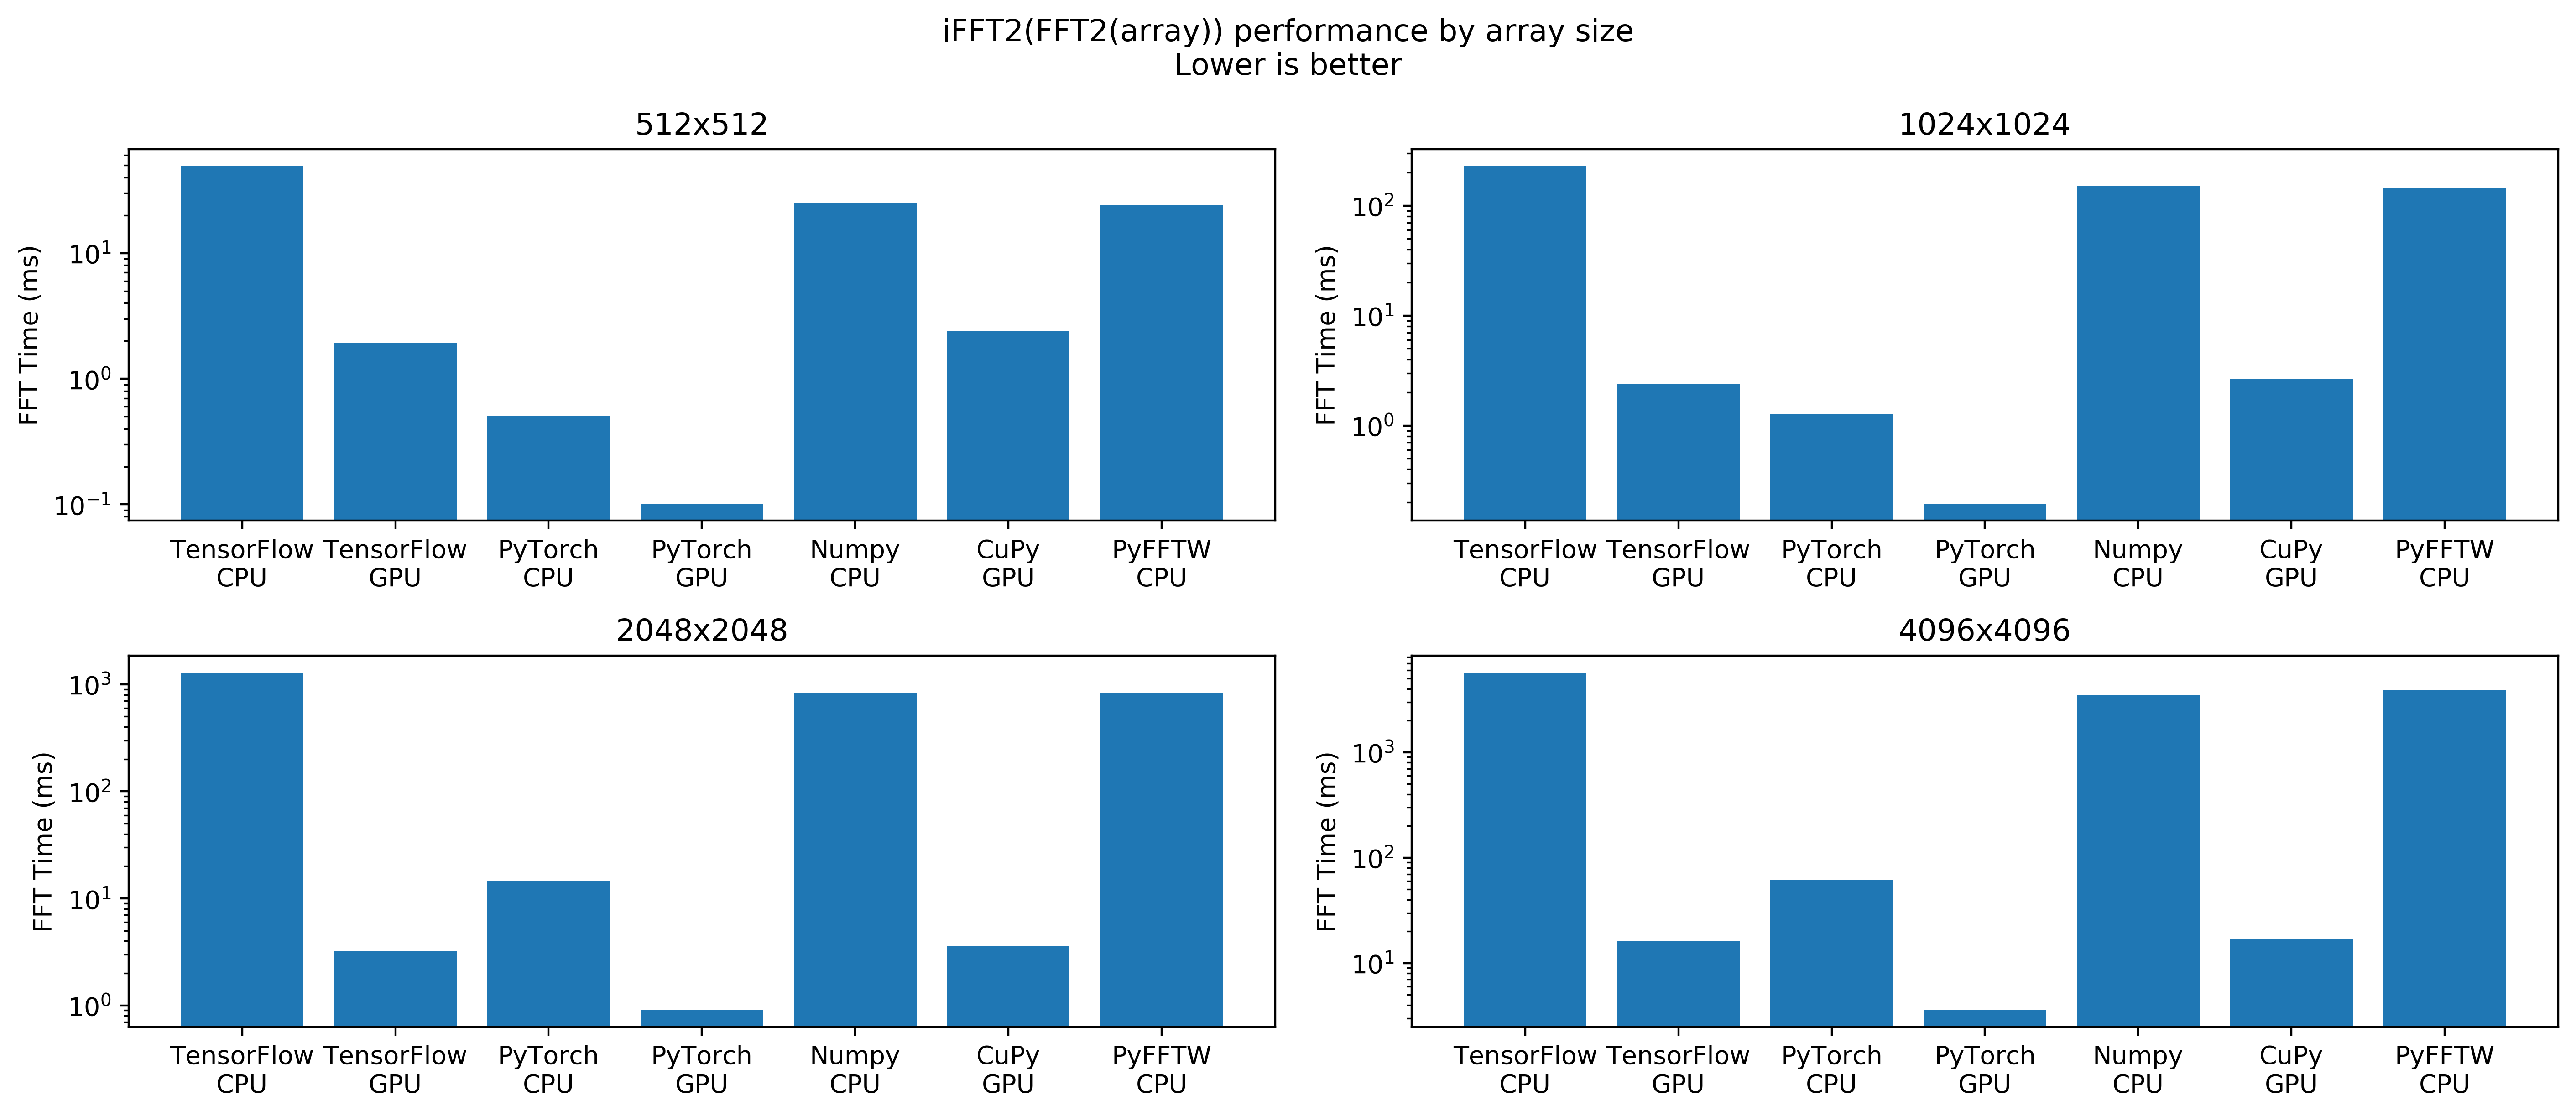

In [71]:
# Plot as function of shape
fig, AX = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(14,6), dpi=400)
# fig.canvas.layout.width = "1400px"
# fig.canvas.layout.height = "600px"
plt.suptitle('iFFT2(FFT2(array)) performance by array size\nLower is better')

for i in range(len(sizes)):
    t = np.array([time[i].average for time in totaltimes]) * 1000 # now in ms
    err = np.array([time[i].stdev for time in totaltimes]) * 1000
    ax = AX.flatten()[i]
    ax.set_title("{}x{}".format(sizes[i], sizes[i]))
    ax.bar(names, t)
    ax.set_yscale('log')
    ax.set_ylabel('FFT Time (ms)')
#plt.savefig('FFT_Speed_by_size.svg')

### Average times (in ms) for a 4k x 4k array

In [63]:
times_4k = np.array([time[-1].average for time in totaltimes]) * 1000
for i in range(len(names)):
    print(" ".join(names[i].split('\n')))
    print(round(times_4k[i], 2))
    
pytorch_time_4k = times_4k[3] 
    
print()
print('4k x 4k iFFT2(FFT2())')
print('PyTorch faster than others by a factor of ')
times_4k = np.array([time[-1].average for time in totaltimes]) * 1000
for i in range(len(names)):
    print(" ".join(names[i].split('\n')))
    print(round(times_4k[i]/pytorch_time_4k, 2))

TensorFlow CPU
5718.92
TensorFlow GPU
16.23
PyTorch CPU
61.28
PyTorch GPU
3.58
Numpy CPU
3486.36
CuPy GPU
17.13
PyFFTW CPU
3907.17

4k x 4k iFFT2(FFT2())
PyTorch faster than others by a factor of 
TensorFlow CPU
1596.6
TensorFlow GPU
4.53
PyTorch CPU
17.11
PyTorch GPU
1.0
Numpy CPU
973.32
CuPy GPU
4.78
PyFFTW CPU
1090.8


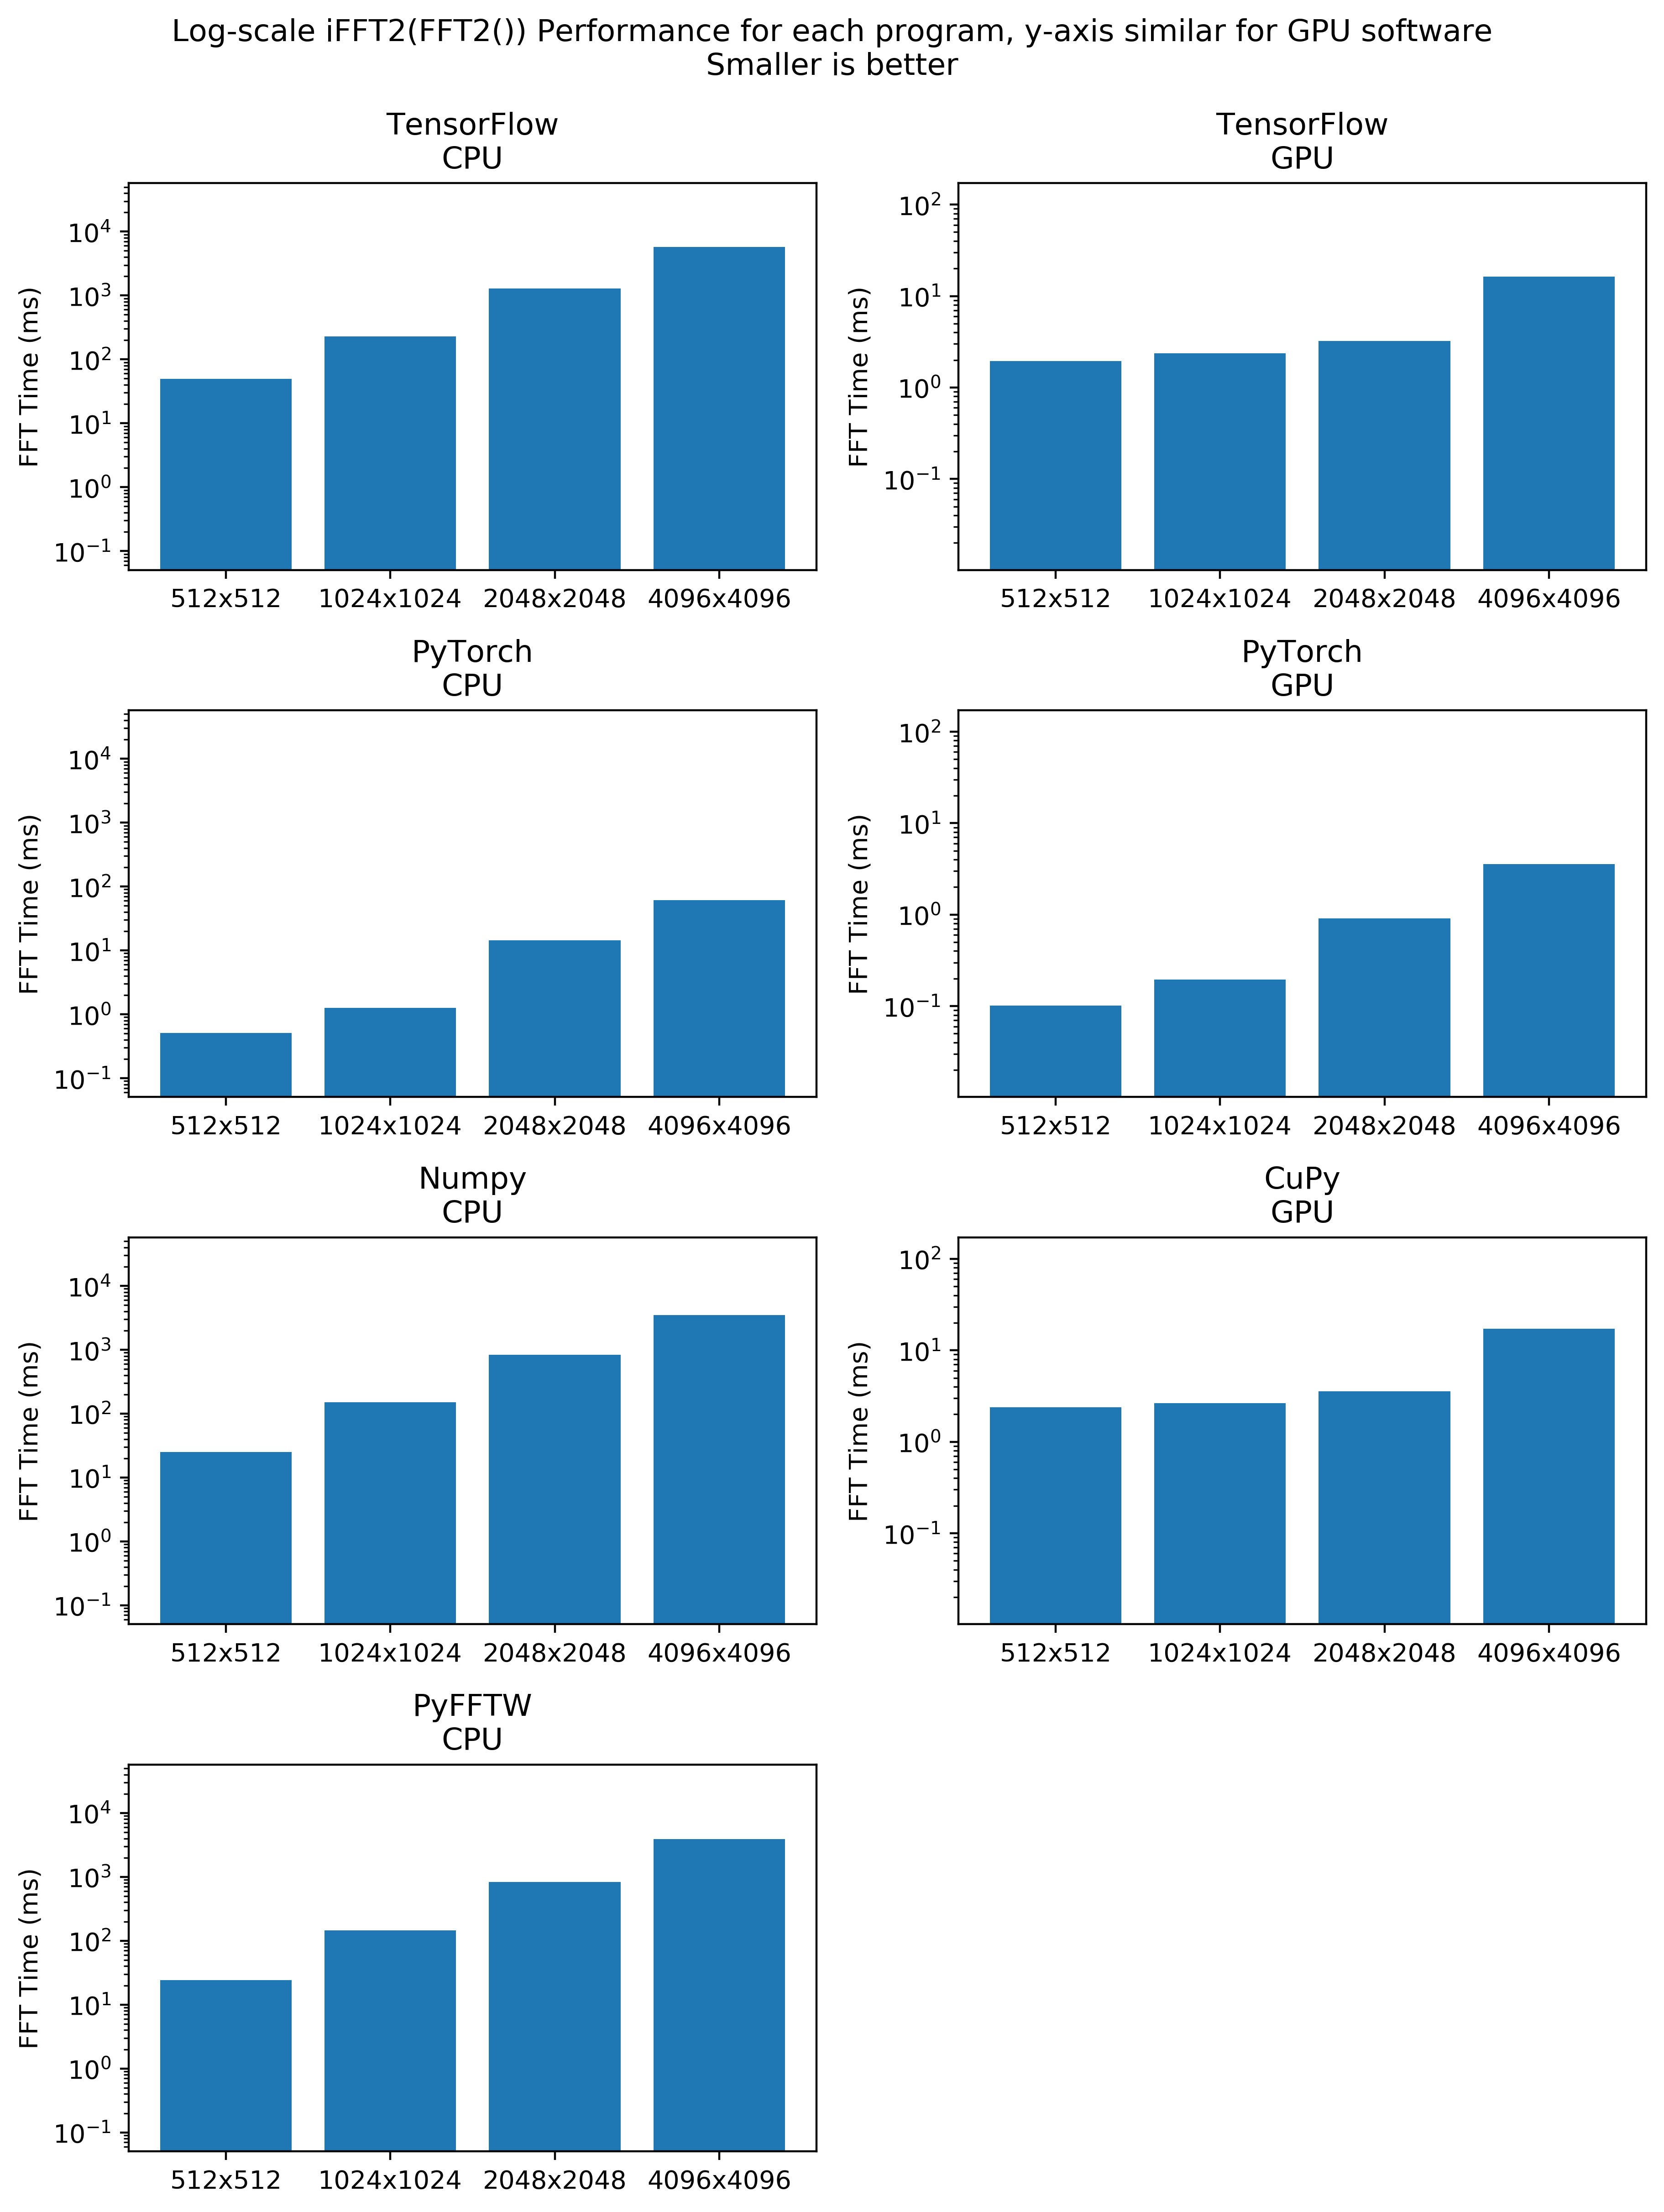

In [72]:
# Plot as function of software
fig, AX = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(9,12), dpi=400)
# fig.canvas.layout.width = "1300px"
# fig.canvas.layout.height = "1000px"
cputimes = [1000 * time.average for times in totaltimes[::2] for time in times]
gputimes = [1000 * time.average for times in totaltimes[1::2] for time in times]

gmx, gmn = max(gputimes), min(gputimes)
cmx, cmn = max(cputimes), min(cputimes)
plt.suptitle('Log-scale iFFT2(FFT2()) Performance for each program, y-axis similar for GPU software\nSmaller is better')

for i in range(len(names)):
    t = np.array([time.average for time in totaltimes[i]]) * 1000 # now in ms
    ax = AX.flatten()[i]
    ax.set_title(names[i])
    sizes_title = ["{}x{}".format(size, size) for size in sizes]
    ax.bar(sizes_title, t)
    ax.set_yscale('log')
    if i %2:
        ax.set_ylim(gmn/10, gmx*10)
    else:
        ax.set_ylim(cmn/10, cmx*10)
    ax.set_ylabel('FFT Time (ms)')
    
AX.flatten()[-1].remove()

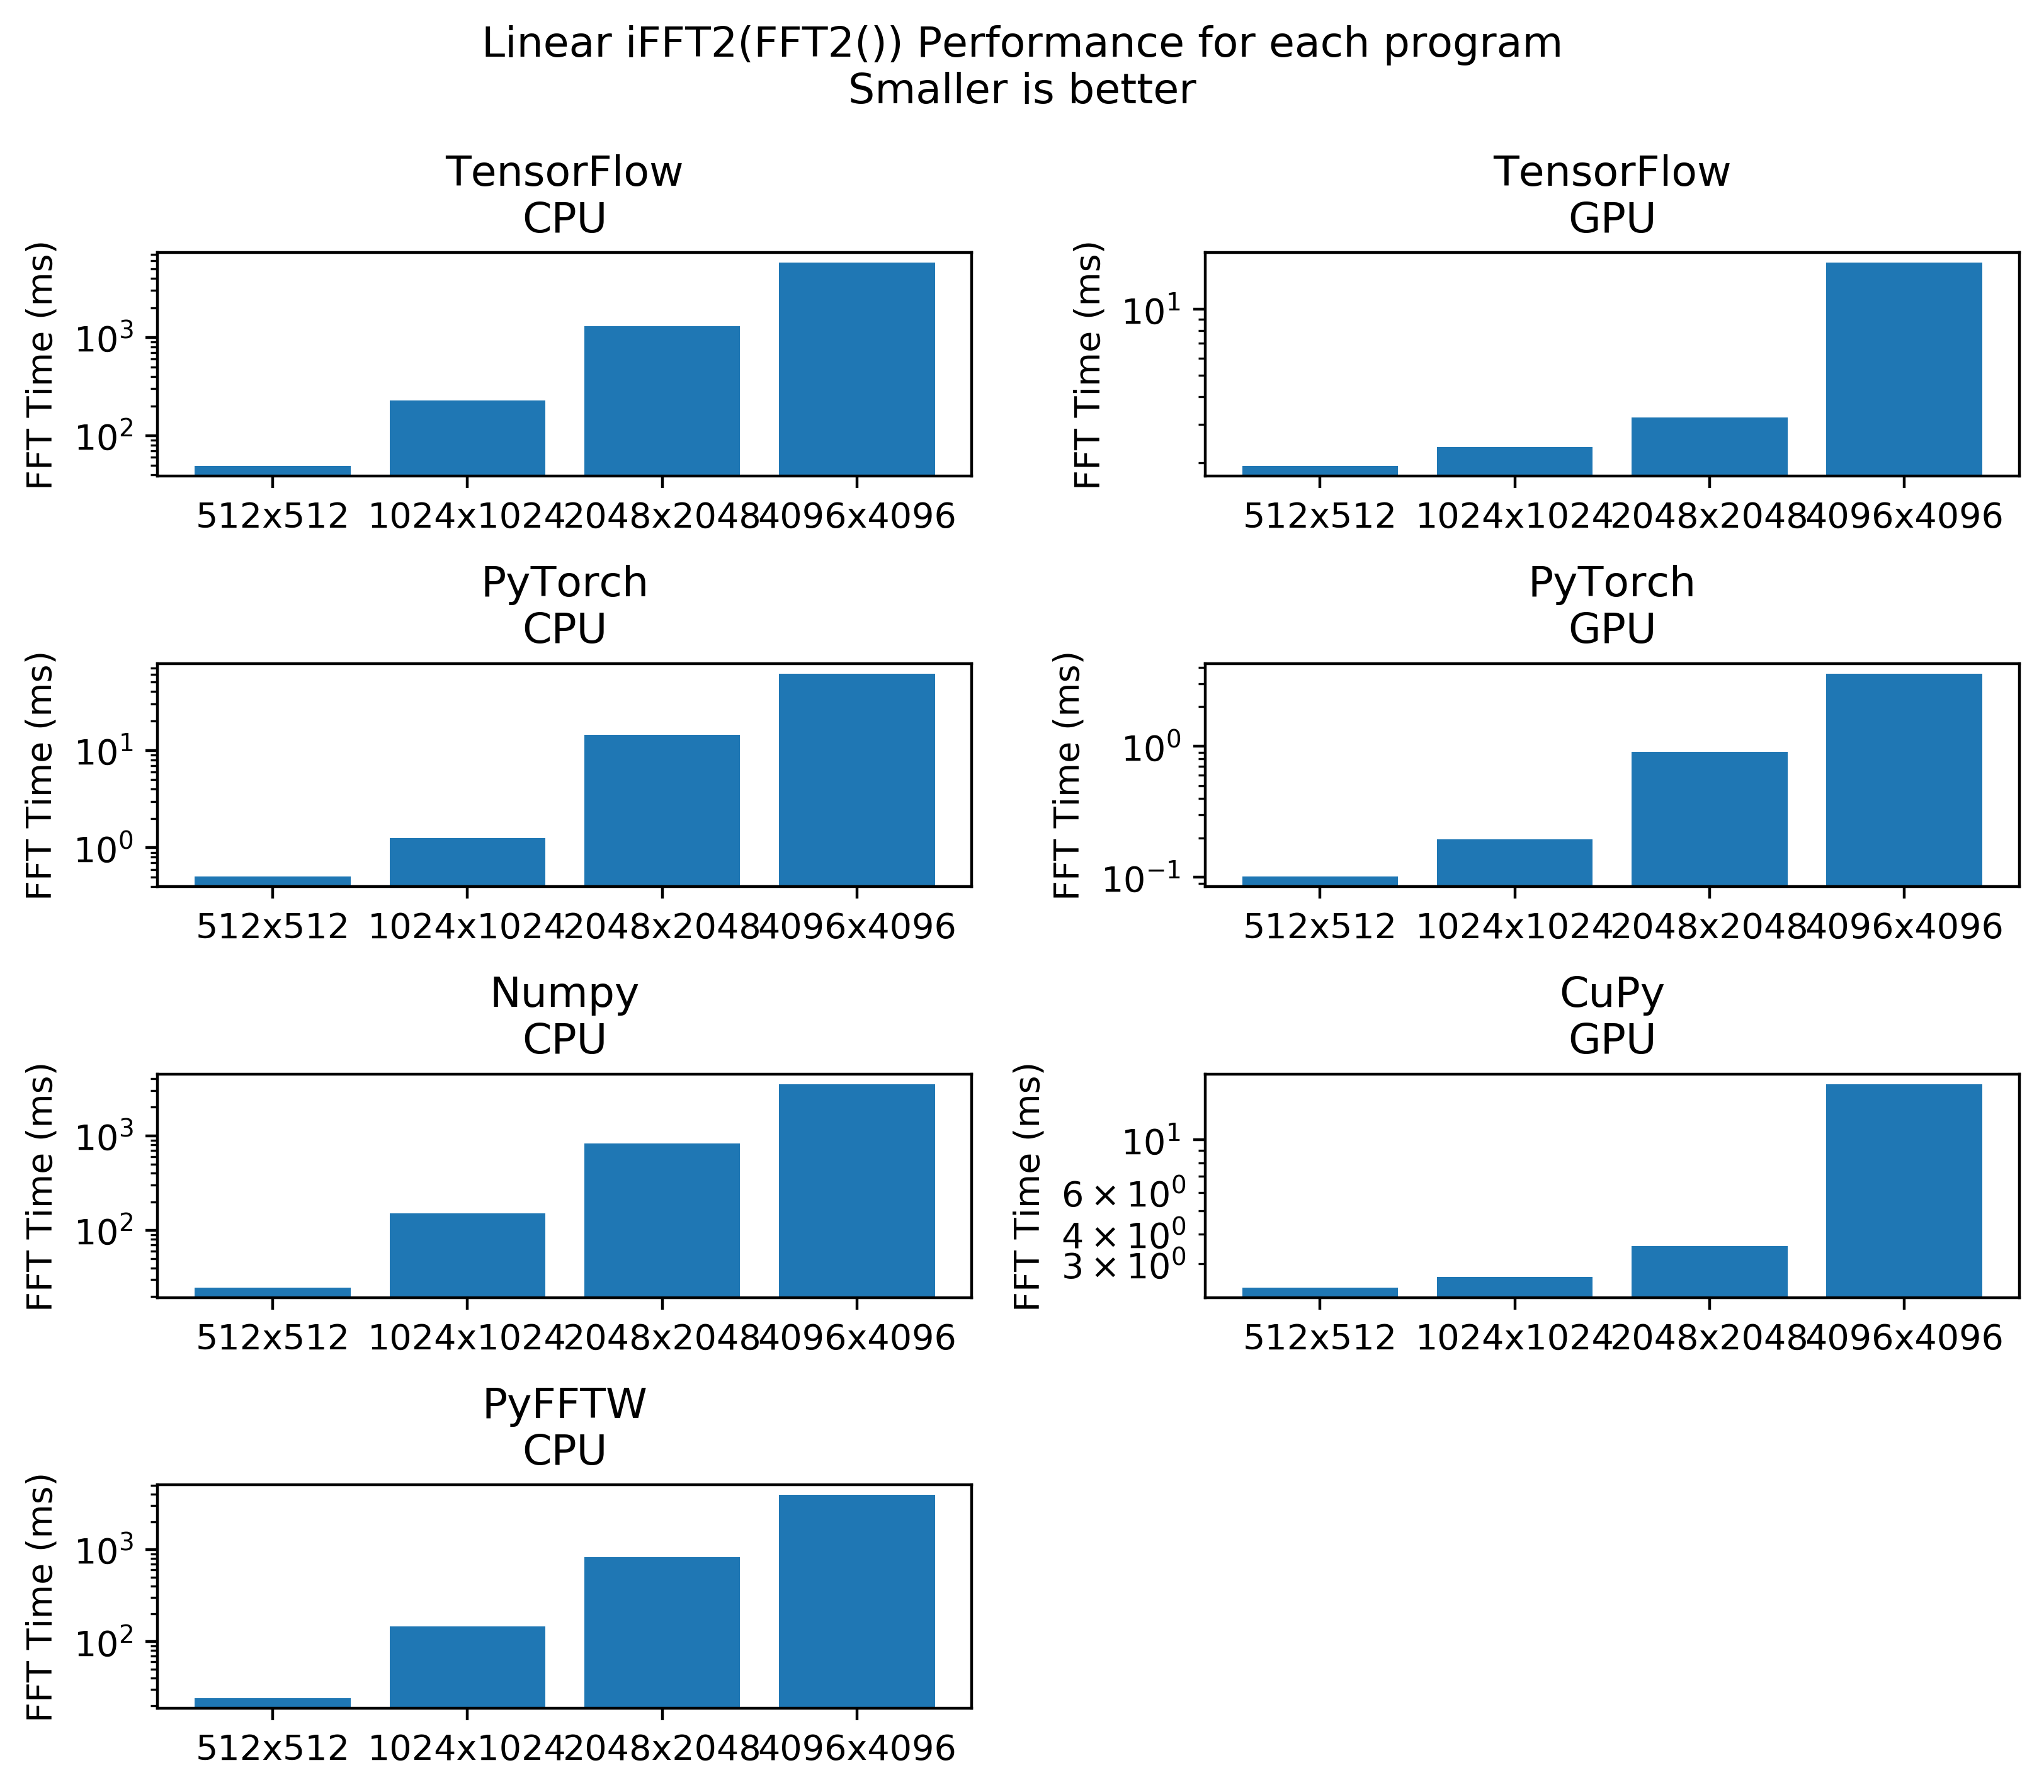

In [75]:
fig, AX = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(8,7), dpi=400)
# fig.canvas.layout.width = "1300px"
# fig.canvas.layout.height = "1000px"
alltimes = [1000 * time.average for times in totaltimes for time in times] # Except Numpy
mx, mn = max(alltimes), min(alltimes)
plt.suptitle('Linear iFFT2(FFT2()) Performance for each program\nSmaller is better')
for i in range(len(names)):
    t = np.array([time.average for time in totaltimes[i]]) * 1000 # now in ms
    ax = AX.flatten()[i]
    ax.set_title(names[i])
    sizes_title = ["{}x{}".format(size, size) for size in sizes]
    ax.bar(sizes_title, t)
    ax.set_yscale('log')
    ax.set_ylabel('FFT Time (ms)')
AX.flatten()[-1].remove()